In [13]:
!pip install pandas openpyxl geopandas matplotlib

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [14]:
data = '../in/datacentermap.csv'

#dc_df = datacenter_dataframe
dc_df = pd.read_csv(data)

# Remove inplace=True
dc_df.drop(['postal', 'link_profile'], axis=1, inplace=True)

mainCountry = 'USA'

mask = dc_df['country'] == mainCountry

dc_df = dc_df[mask]

# Create a GeoDataFrame
dc_gdf = gpd.GeoDataFrame(dc_df, geometry=gpd.points_from_xy(dc_df.longitude, dc_df.latitude))

# Define or identify the coordinate reference system (CRS)
# For the United States, you can use EPSG:4326 (WGS 84) which is commonly used for latitude and longitude coordinates
dc_gdf.crs = "EPSG:4326"

# Loading custom us state shapefile
states_map = gpd.read_file('../in/States_shapefile-shp/States_shapefile.shp')

In [15]:
power_df = pd.read_excel('../in/avgprice_annual.xlsx', skiprows=1)

#only keeping power prices from 2020
power_df = power_df[power_df['Year'] == 2020]

#only keeping "total electric industry" as the industry sector as its the only one that has all 51 states.
power_df = power_df[power_df['Industry Sector Category'] == 'Total Electric Industry']


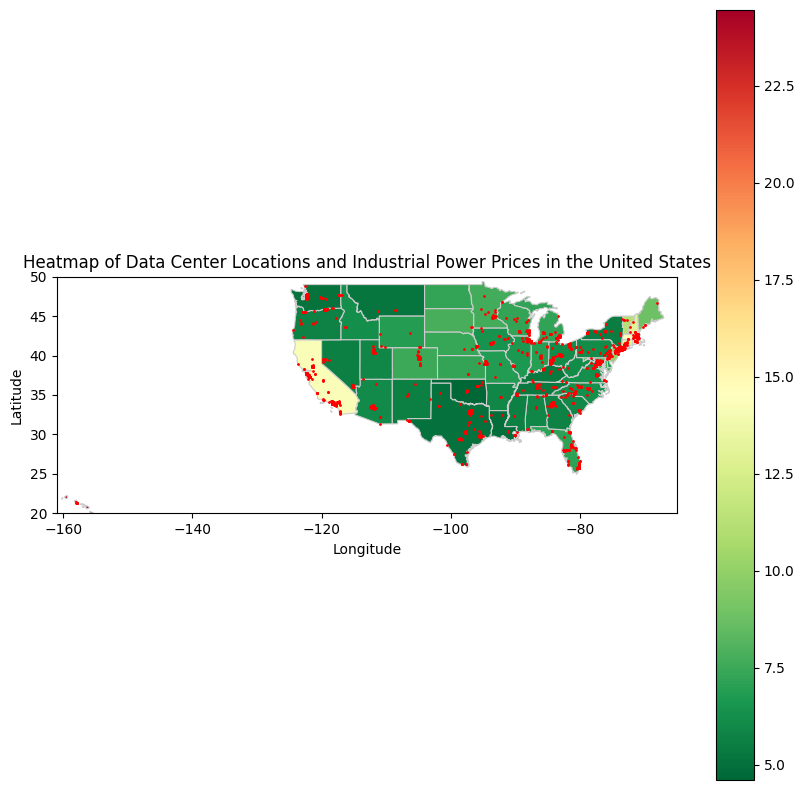

In [16]:
merged_data = states_map.merge(power_df, how='left', left_on='State_Code', right_on='State')

power_sector = 'Industrial'

# Plot the custom map
fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column=power_sector, cmap='RdYlGn_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Plot the data points on the map
dc_gdf.plot(ax=ax, color='red', markersize=1)

# Set the extent of the plot to focus on the United States

#ax.set_xlim(-180, -65)  # Adjust these values based on your preference

ax.set_xlim(-161, -65)  # Adjust these values based on your preference

#ax.set_xlim(-130, -65)  # Adjust these values based on your preference
ax.set_ylim(20, 50)     # Adjust these values based on your preference

plt.title(f'Heatmap of Data Center Locations and {power_sector} Power Prices in the United States')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [17]:
print(states_map.columns)
print(dc_df.columns)

Index(['FID', 'Program', 'State_Code', 'State_Name', 'Flowing_St', 'FID_1',
       'geometry'],
      dtype='object')
Index(['name', 'id', 'latitude', 'longitude', 'address', 'city', 'state',
       'country'],
      dtype='object')


In [18]:
def uppercase_df(input_df):
    return input_df.map(lambda x: x.upper() if isinstance(x, str) else x)

In [19]:
state_counts = dc_df['state'].value_counts().reset_index()
# Convert all string values in the dataframe to uppercase since the shapefile uses uppercase state names
state_counts = uppercase_df(state_counts)
state_counts.columns = ['State_Name', 'Datacenter_Count']
state_counts.head()


,State_Name,Datacenter_Count
0,VIRGINIA,311
1,CALIFORNIA,259
2,TEXAS,241
3,OHIO,150
4,NEW YORK,128


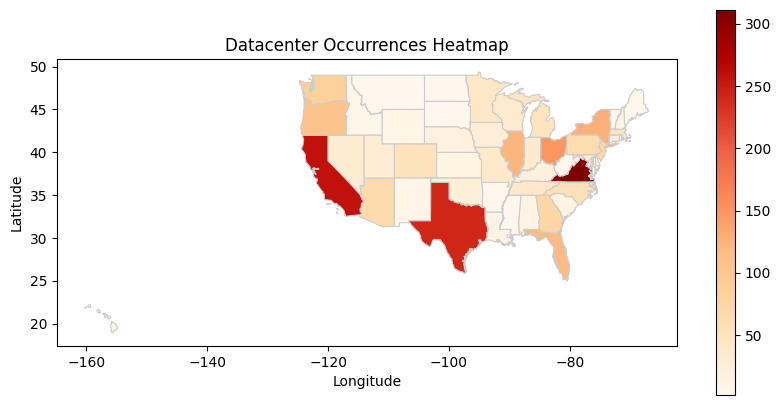

In [26]:
# Merge the state counts with the state shapefile map based on state names
merged_data = merged_data.merge(state_counts, how='left', on='State_Name')

# Plot the map with state occurrences heatmap
fig, ax = plt.subplots(figsize=(10, 5))
merged_data.plot(column='Datacenter_Count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Datacenter Occurrences Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [27]:
internet_df = pd.read_csv('../in/average-internet-speed-by-state-2024.csv')

internet_df = uppercase_df(internet_df)

internet_df.rename(columns={'state': 'State_Name'}, inplace=True)

merged_data = merged_data.merge(internet_df, how='left', on='State_Name')



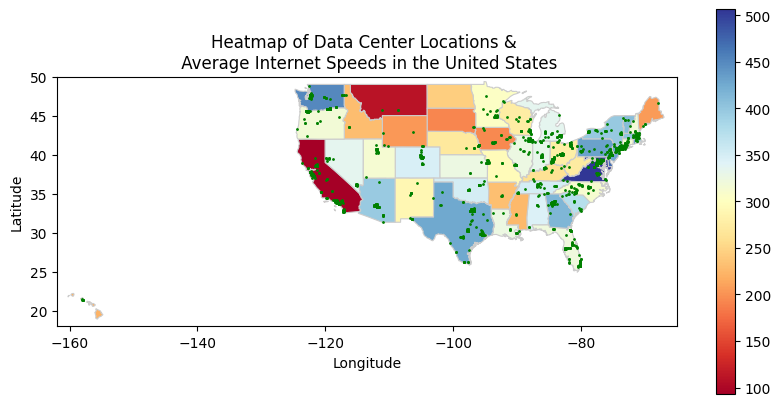

In [28]:
# Plot the custom map
fig, ax = plt.subplots(figsize=(10, 5))
merged_data.plot(column='AverageInternetSpeedMbps', cmap='RdYlBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Plot the data points on the map
dc_gdf.plot(ax=ax, color='green', markersize=1)

# Set the extent of the plot to focus on the United States

#ax.set_xlim(-180, -65)  # Adjust these values based on your preference

ax.set_xlim(-162, -65)  # Adjust these values based on your preference

#ax.set_xlim(-130, -65)  # Adjust these values based on your preference
ax.set_ylim(18, 50)     # Adjust these values based on your preference

plt.title('Heatmap of Data Center Locations & \n Average Internet Speeds in the United States')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## State temperatures

## Remember to find missing temperatures for hawaii, alaska and district of columbia

First, we import the average annual temperature by states for 2023.

In [81]:
state_temp_file = os.path.join('..','in','state_temp.csv')
state_temp = pd.read_csv(state_temp_file, skiprows=4)
state_temp.head()

,ID,Name,Value,Anomaly (1901-2000 base period),Rank,1901-2000 Mean
0,1,Alabama,65.4,2.3,127,63.1
1,2,Arizona,60.8,1.4,105,59.4
2,3,Arkansas,62.9,2.5,126,60.4
3,4,California,58.2,0.8,92,57.4
4,5,Colorado,45.9,1.3,101,44.6


Then, we rename the "name" colum to "State_Name" and the "value" column to "temperature".

In [82]:
state_temp.rename(columns={'Name' : 'State_Name', 'Value' : 'temperature'}, inplace=True)

state_temp = state_temp[['State_Name','temperature']]

state_temp.head()

,State_Name,temperature
0,Alabama,65.4
1,Arizona,60.8
2,Arkansas,62.9
3,California,58.2
4,Colorado,45.9


Then we convert the temperatures from fahrenheit to celsius by applying a custom funtion to the column.

In [83]:
def fahrenheit_to_celsius(fahrenheit):
    """
    Convert Fahrenheit to Celsius.

    Parameters:
    fahrenheit (float): Temperature in Fahrenheit.

    Returns:
    float: Temperature in Celsius.
    """
    celsius = (fahrenheit - 32) * 5.0/9.0
    return celsius

state_temp['temperature'] = state_temp['temperature'].apply(fahrenheit_to_celsius)

state_temp.head()

,State_Name,temperature
0,Alabama,18.555556
1,Arizona,16.000000
2,Arkansas,17.166667
3,California,14.555556
4,Colorado,7.722222


In [80]:
#converting to uppercase again, because thats what the merged_data shapefile uses for state names.
state_temp = uppercase_df(state_temp)

merged_data = merged_data.merge(state_temp, how='left', on='State_Name')

merged_data.head()


,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,Year,State,Industry Sector Category,Residential,Commercial,Industrial,Transportation,Other,Total,Datacenter_Count,AverageInternetSpeedMbps,temperature
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2020,AL,Total Electric Industry,12.58,11.55,5.87,0.00,NaN,9.84,11.0,344.6,18.555556
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",2020,AK,Total Electric Industry,22.57,19.58,15.88,0.00,NaN,19.82,NaN,285.1,NaN
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",2020,AZ,Total Electric Industry,12.27,10.11,6.07,9.38,NaN,10.44,66.0,396.1,16.000000
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",2020,AR,Total Electric Industry,10.41,8.61,5.89,13.32,NaN,8.32,3.0,230.4,17.166667
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",2020,CA,Total Electric Industry,20.45,17.53,14.27,10.07,NaN,18.00,259.0,93.0,14.555556


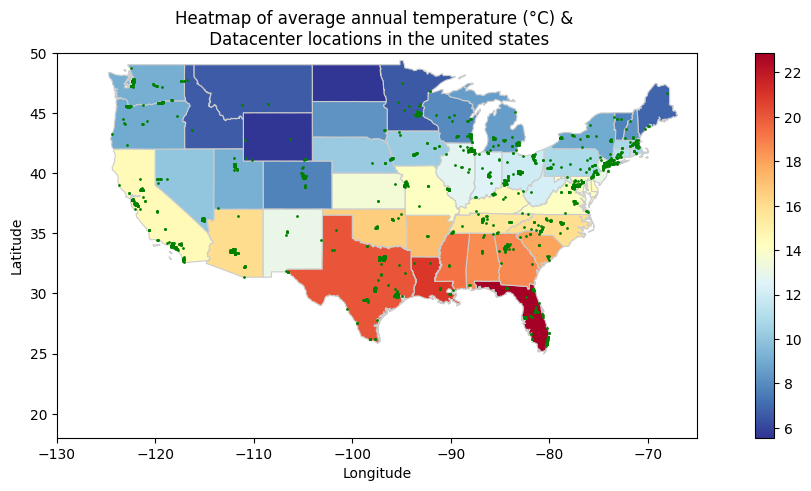

In [99]:
# Plot the custom map
fig, ax = plt.subplots(figsize=(15, 5))
merged_data.plot(column='temperature', cmap='RdYlBu_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Plot the data points on the map
dc_gdf.plot(ax=ax, color='green', markersize=1)

# Set the extent of the plot to focus on the United States

#ax.set_xlim(-180, -65)  # Adjust these values based on your preference

#ax.set_xlim(-162, -65)  # Adjust these values based on your preference

ax.set_xlim(-130, -65)  # Adjust these values based on your preference
ax.set_ylim(18, 50)     # Adjust these values based on your preference

plt.title('Heatmap of average annual temperature (°C) & \n Datacenter locations in the united states')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()